# PTS Cointegration Method Visualization

In [1]:
import pandas as pd

from Helpers.FunctHelpers import *
from Helpers.PlotHelpers import *

In [2]:
# Download data

tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

start_date = pd.to_datetime('2022-01-01') # train 12 months
end_date = pd.to_datetime('2023-07-01') # test 6 months

data = download_data(names, start_date, end_date)

[*********************100%***********************]  65 of 65 completed


6 Failed downloads:
['RE', 'PBCT', 'BRK.B', 'FRC', 'WLTW']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [3]:
# Split into train and test data

train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2022-12-31')
test_start = pd.to_datetime('2023-01-01')
test_end = pd.to_datetime('2023-07-01')

train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)
print(train_data.shape, test_data.shape)

(251, 59) (124, 59)


In [4]:
# Check for stationarity using the Augmented Dickey-Fuller test

I0_list = adf_check_stationarity(train_data)
print(f'These series are I(0): {I0_list}')

columns_to_drop = [col for col in I0_list if col in data.columns]
if columns_to_drop:
    data.drop(I0_list, axis=1, inplace=True)
    print(f'I0 series dropped')

These series are I(0): ['BLK', 'GS', 'JPM', 'MMC', 'MS', 'MSCI', 'RF', 'SPGI', 'TROW']
I0 series dropped


In [5]:
# Check for cointegrated pairs

pvalue_matrix, cointegrated_pairs, coint_constants = find_cointegrated_pairs(train_data, autolag='AIC')
print(f'Chosen pairs: {len(cointegrated_pairs)} from {round(len(data.columns) * (len(data.columns) - 1) / 2)} posssible pairs')

Chosen pairs: 97 from 1225 posssible pairs


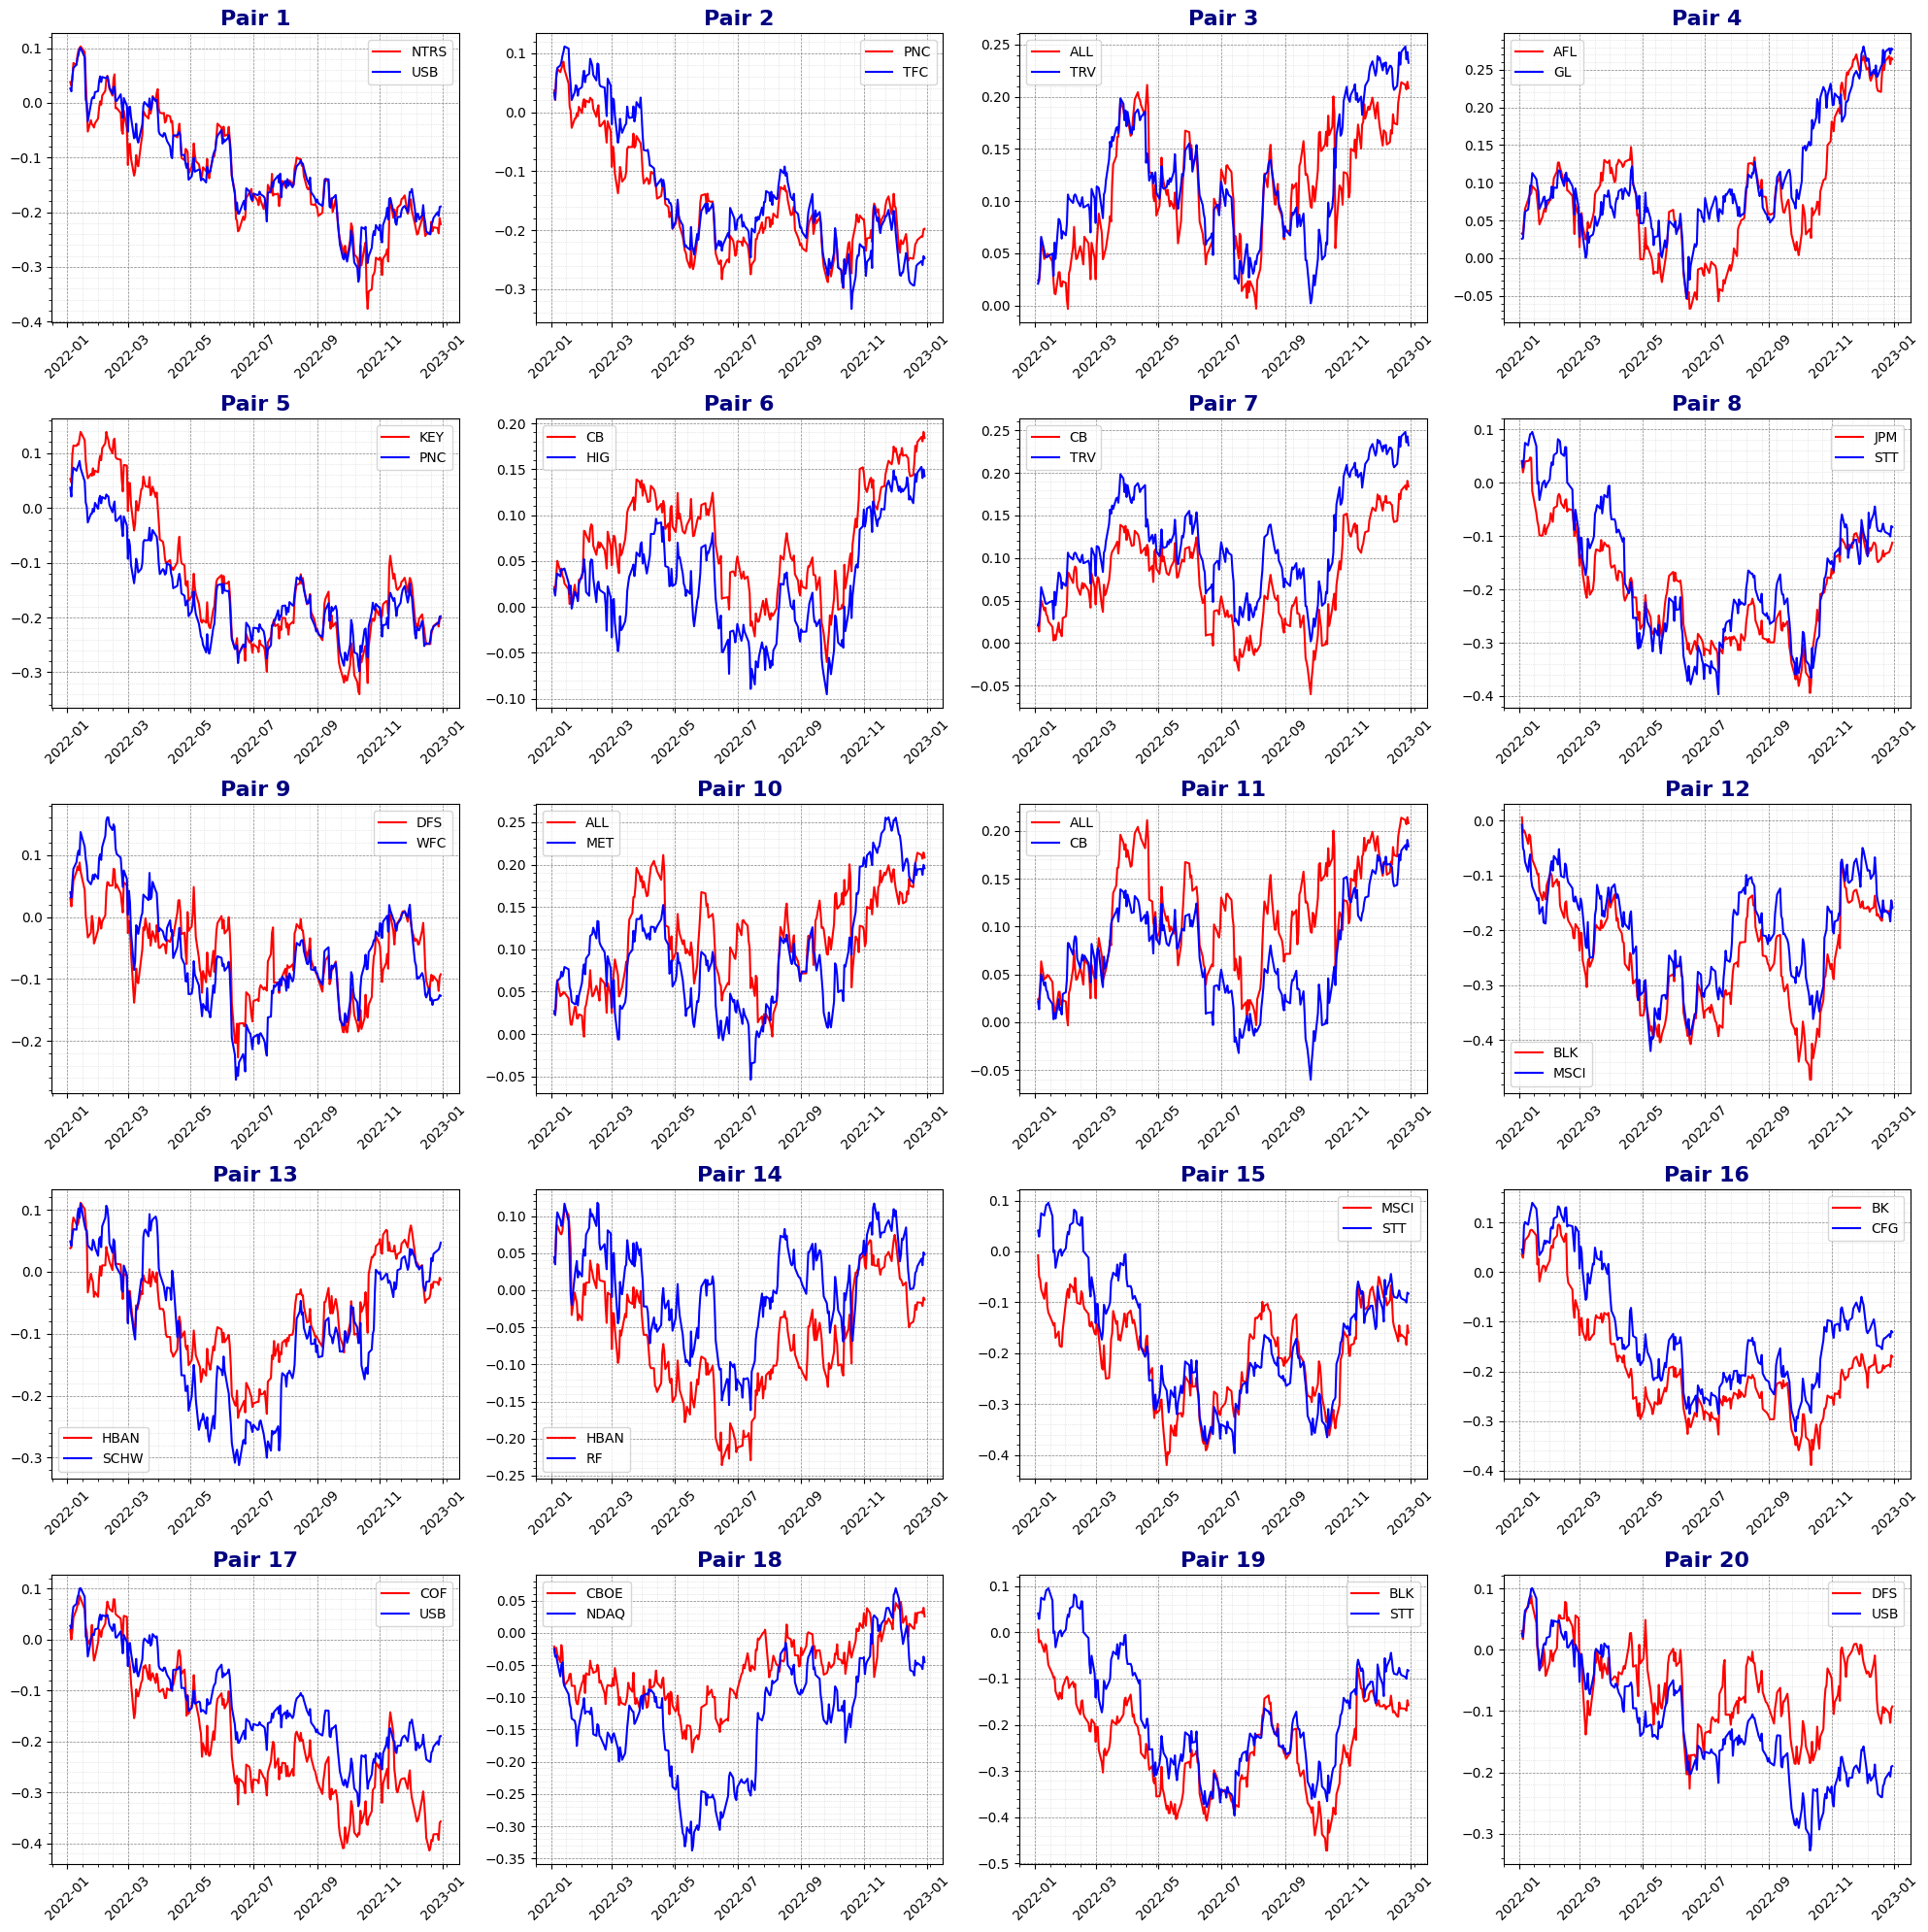

In [6]:
# Calculate SSD and select 20 cointegrated pairs with lowest SSD

train_data_cum = train_data.pct_change().cumsum().dropna(axis=0)

ssd_train = find_ssd_pair(train_data_cum, cointegrated_pairs)
pairs = select_lowest_ssd_pair(ssd_train)

plot_min_ssd_pairs(pairs, train_data_cum)

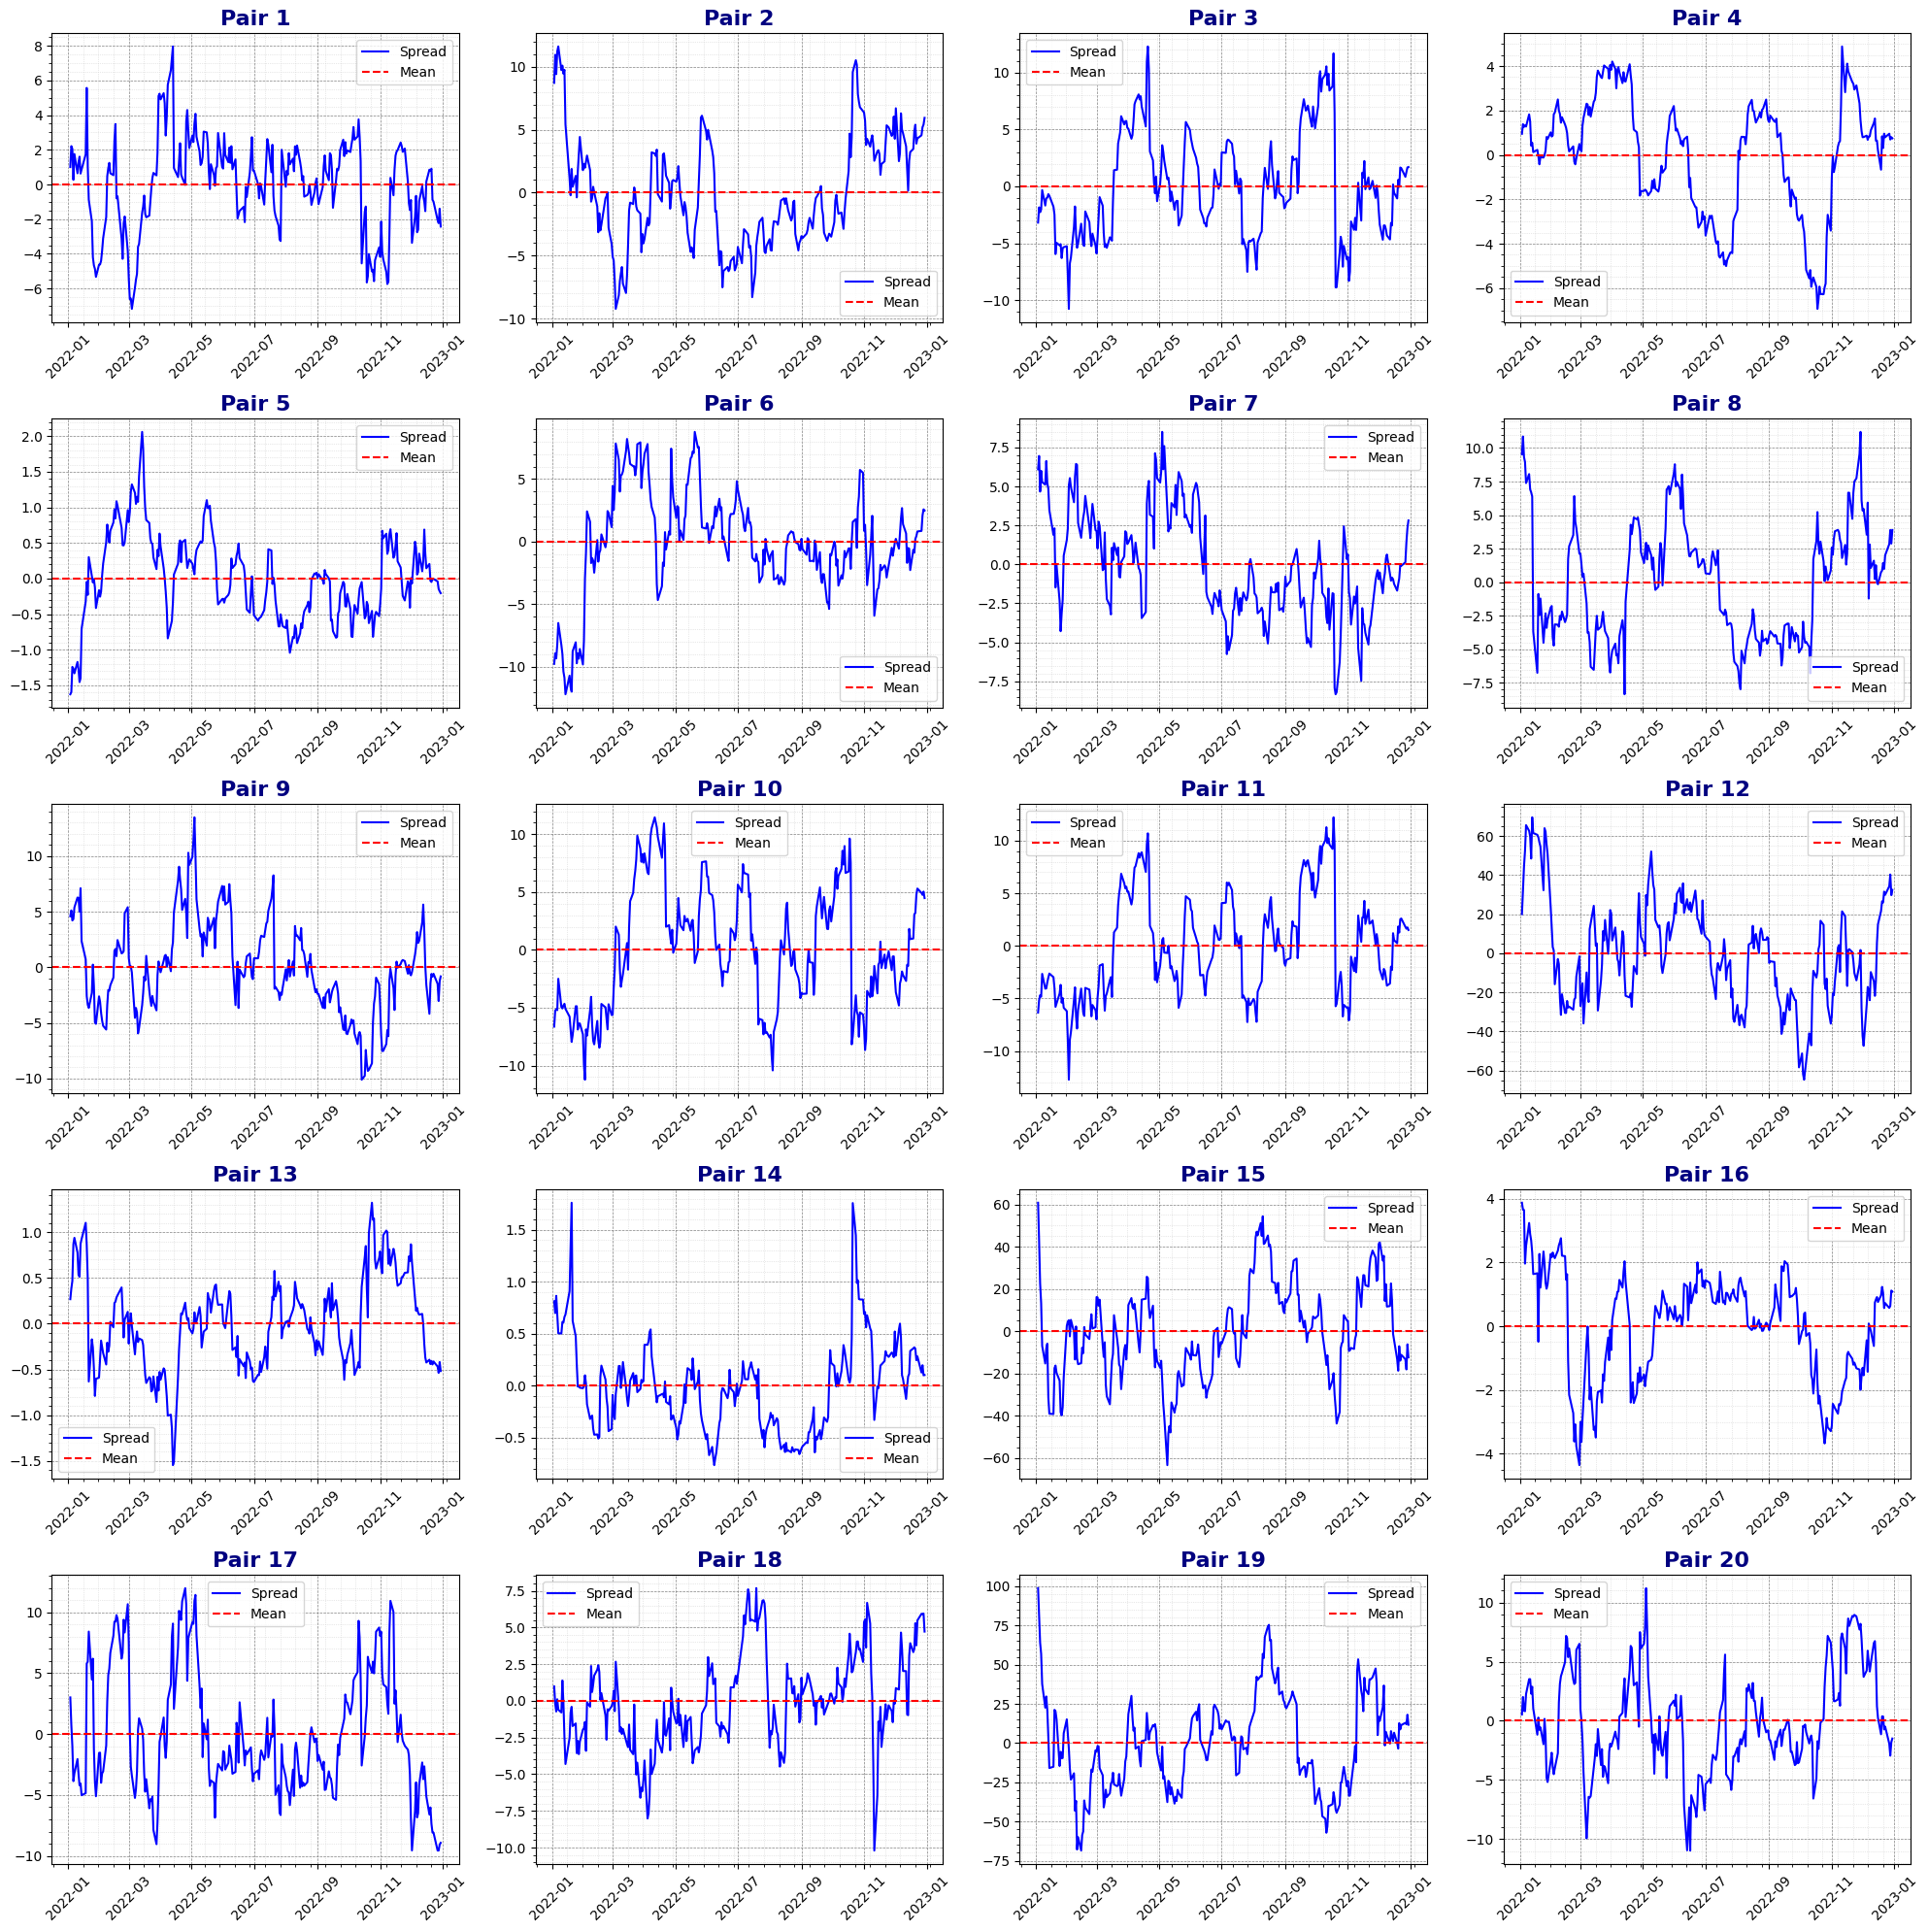

In [7]:
# Calculate the spread for the selected pairs and plot to check for stationarity (mean = 0)

spread_pairs = get_spread_pairs(train_data, pairs)
plot_spread_pairs(spread_pairs)

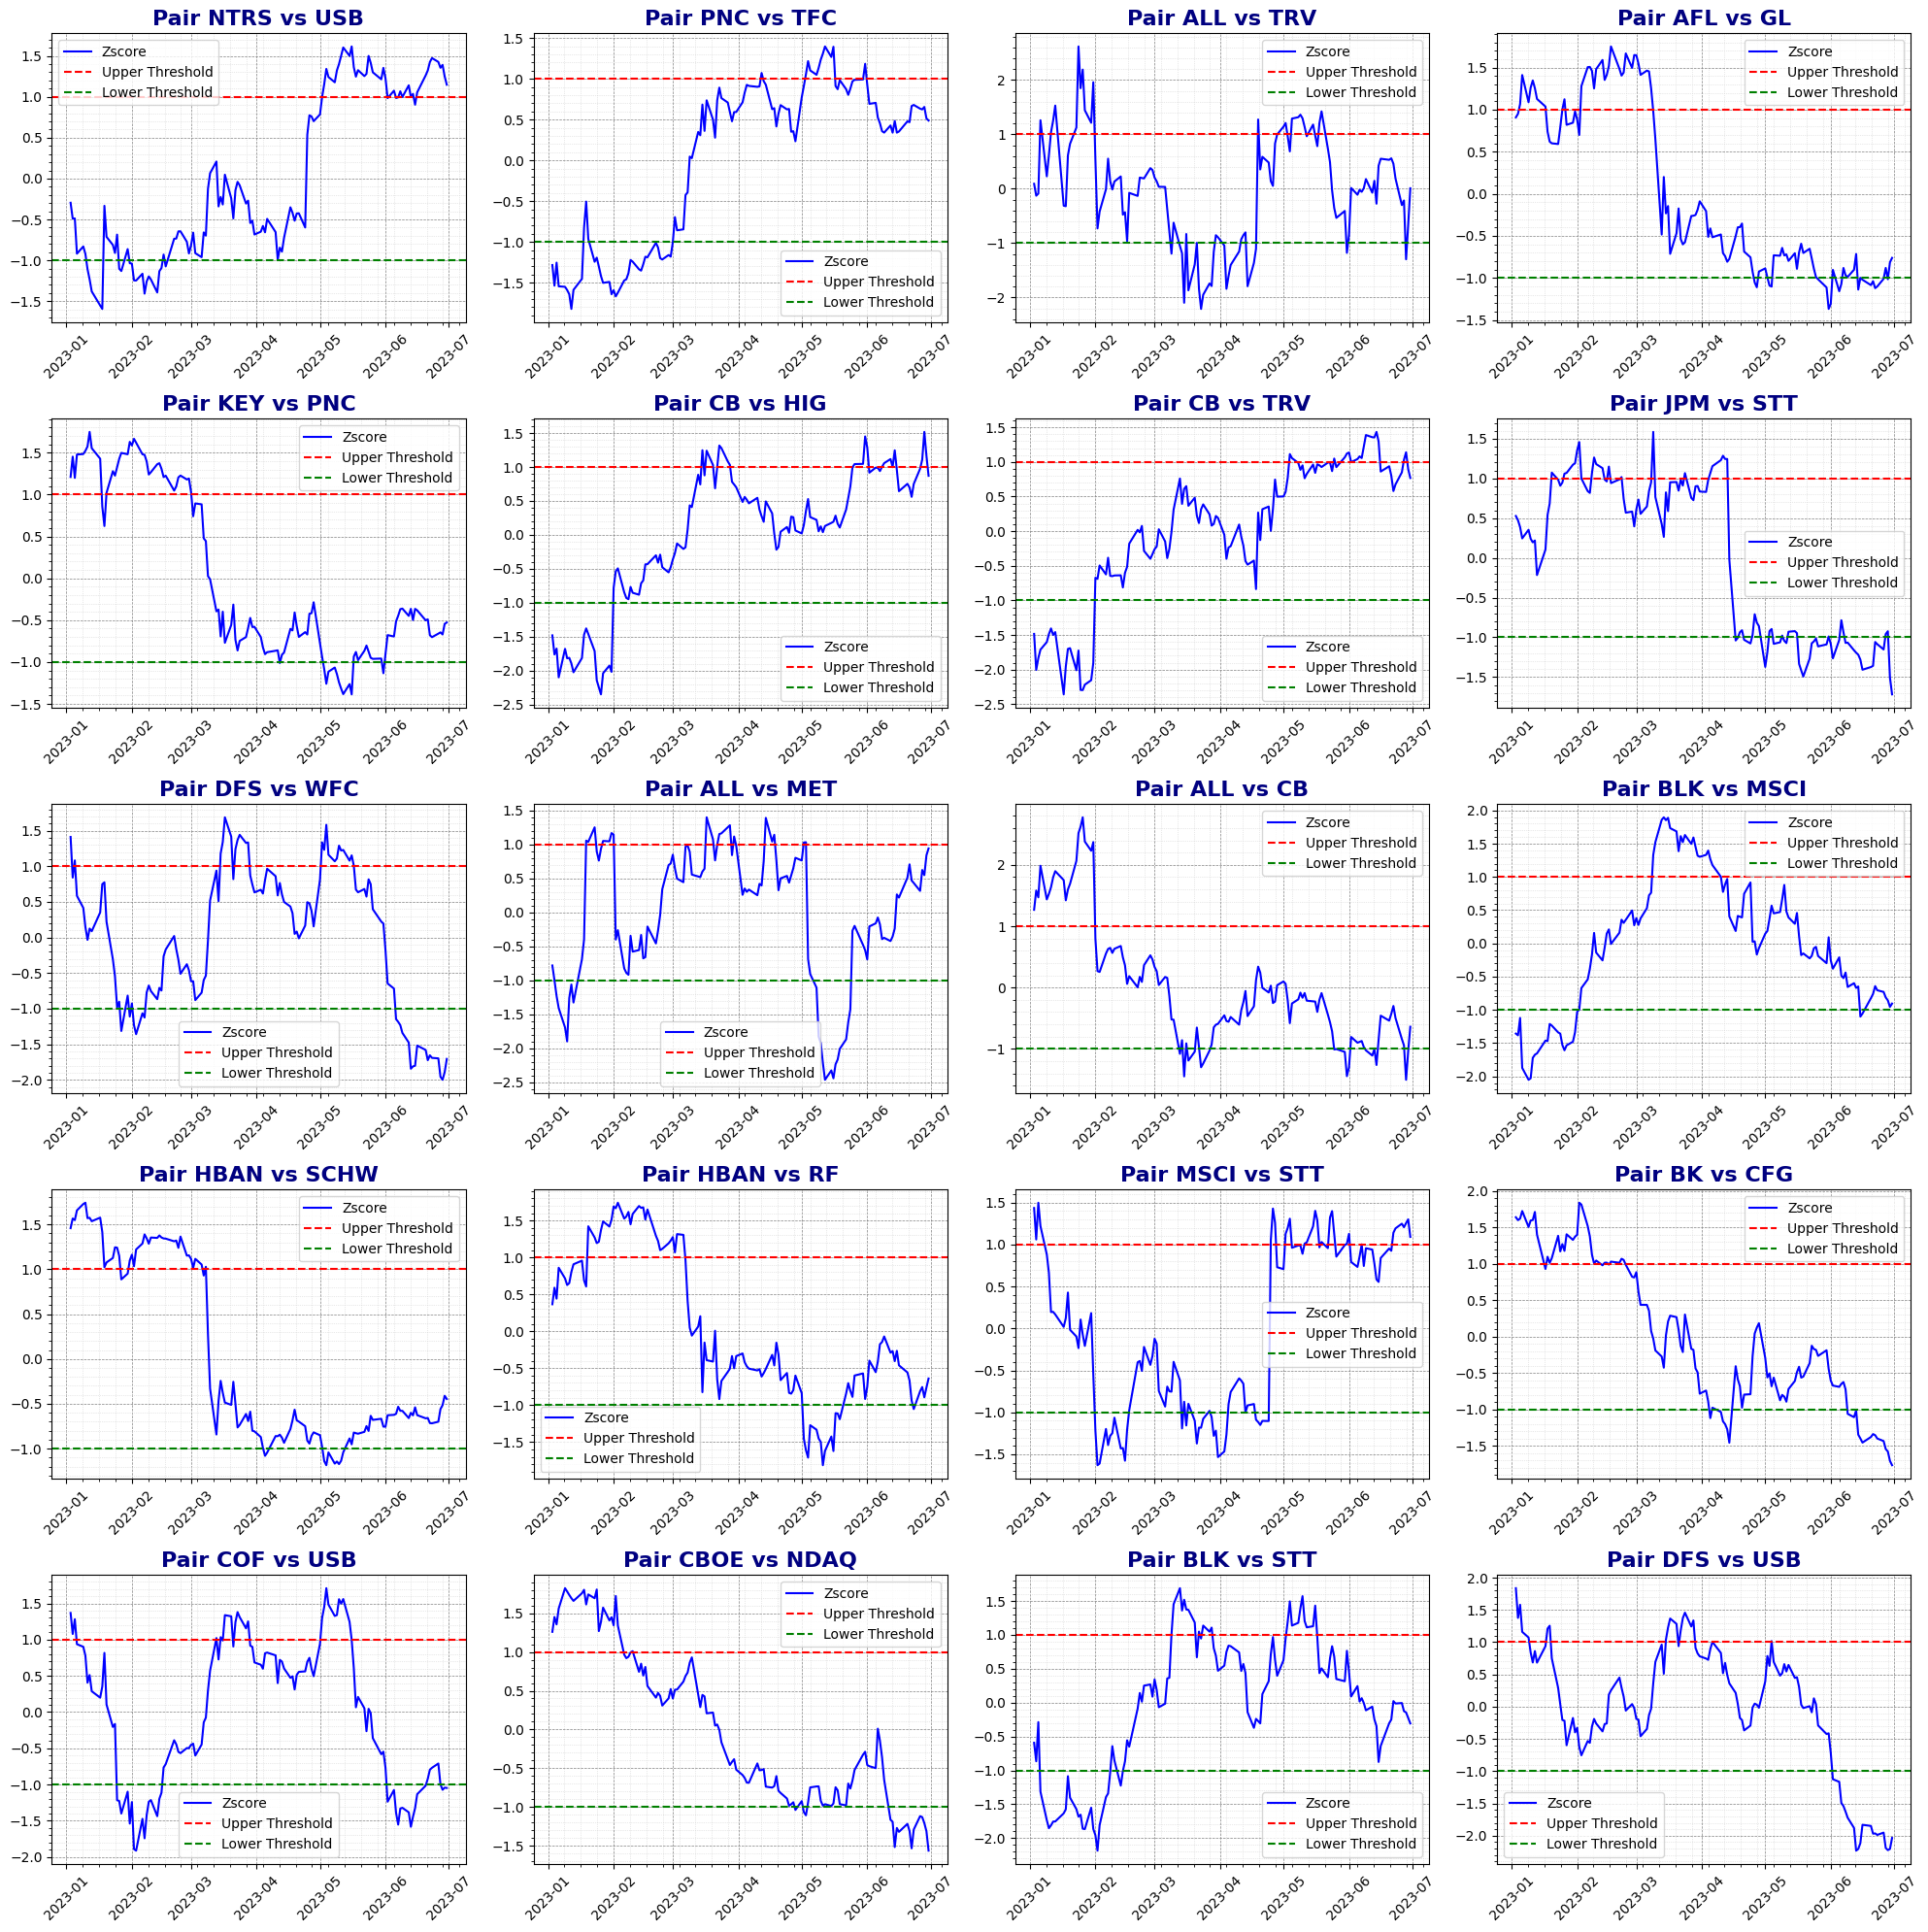

In [8]:
# Generate trading signals for the selected pairs

signals = get_trading_signals_coint(test_data, pairs, train_data)
plot_zscores(signals, pairs) # stdev is kept at one otherwise almost no trades are made

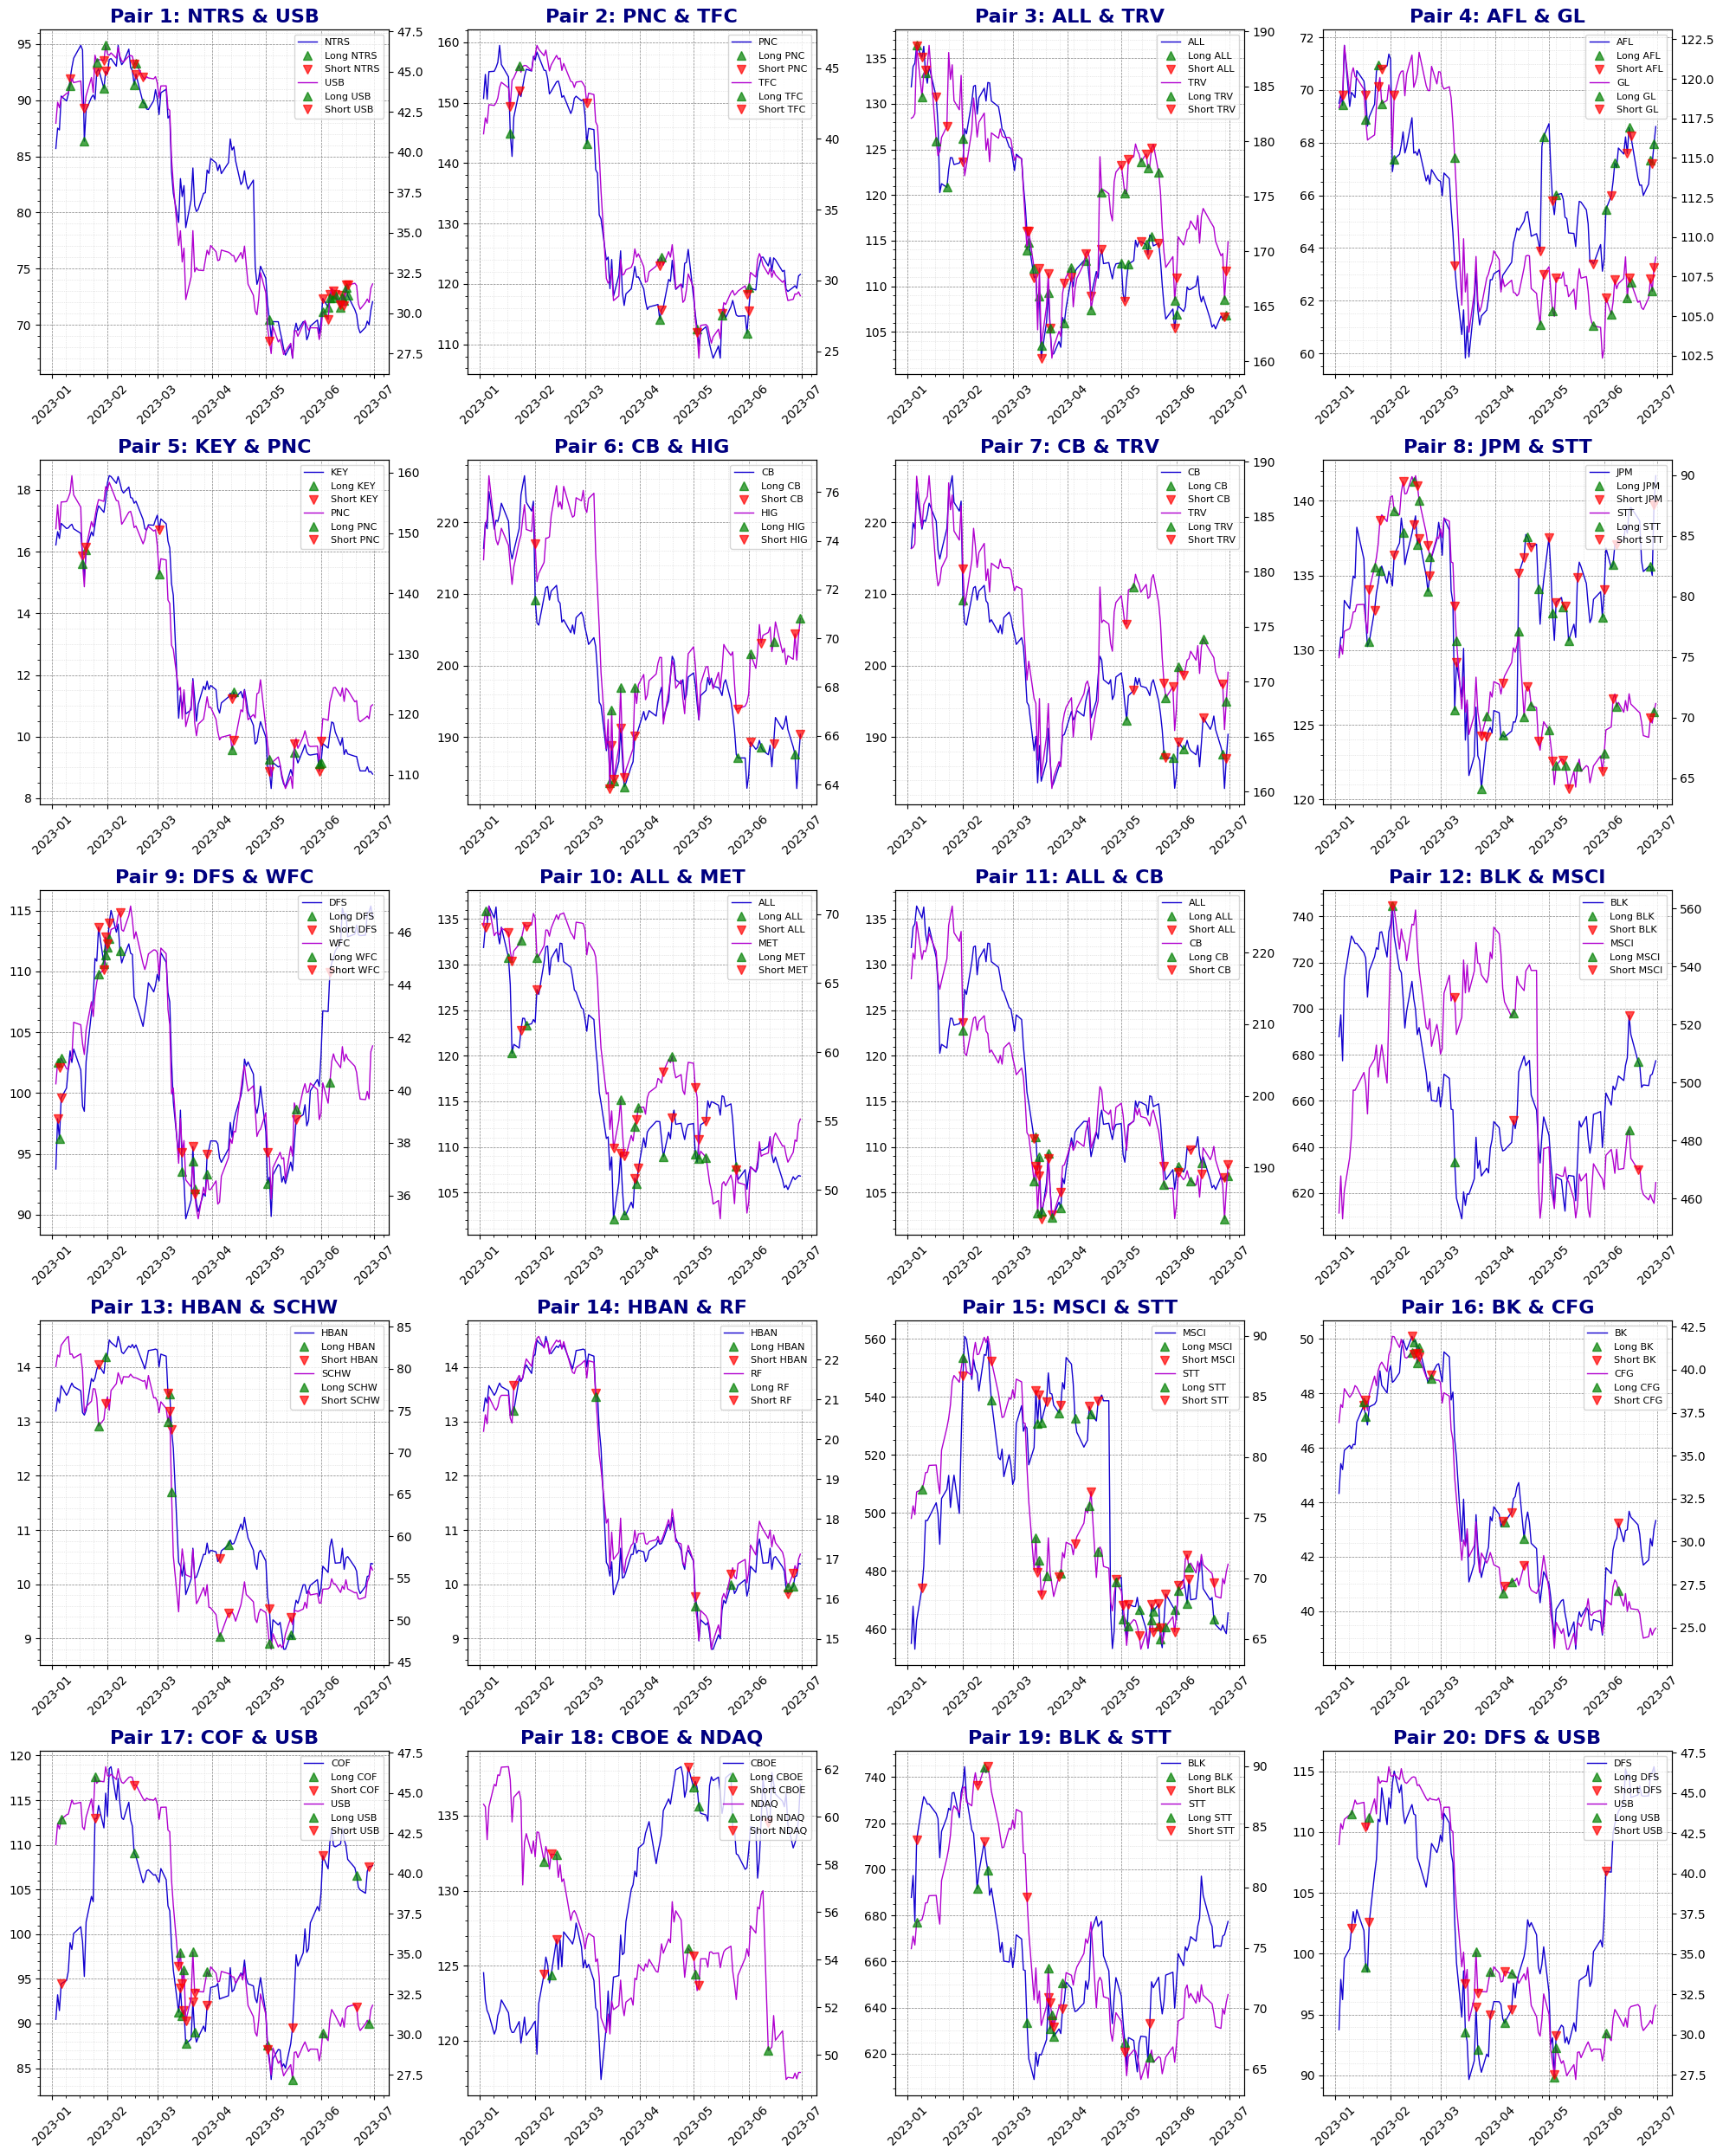

In [9]:
#plot_signals_pairs 

plot_signals_prices_pairs(test_data, signals, pairs)

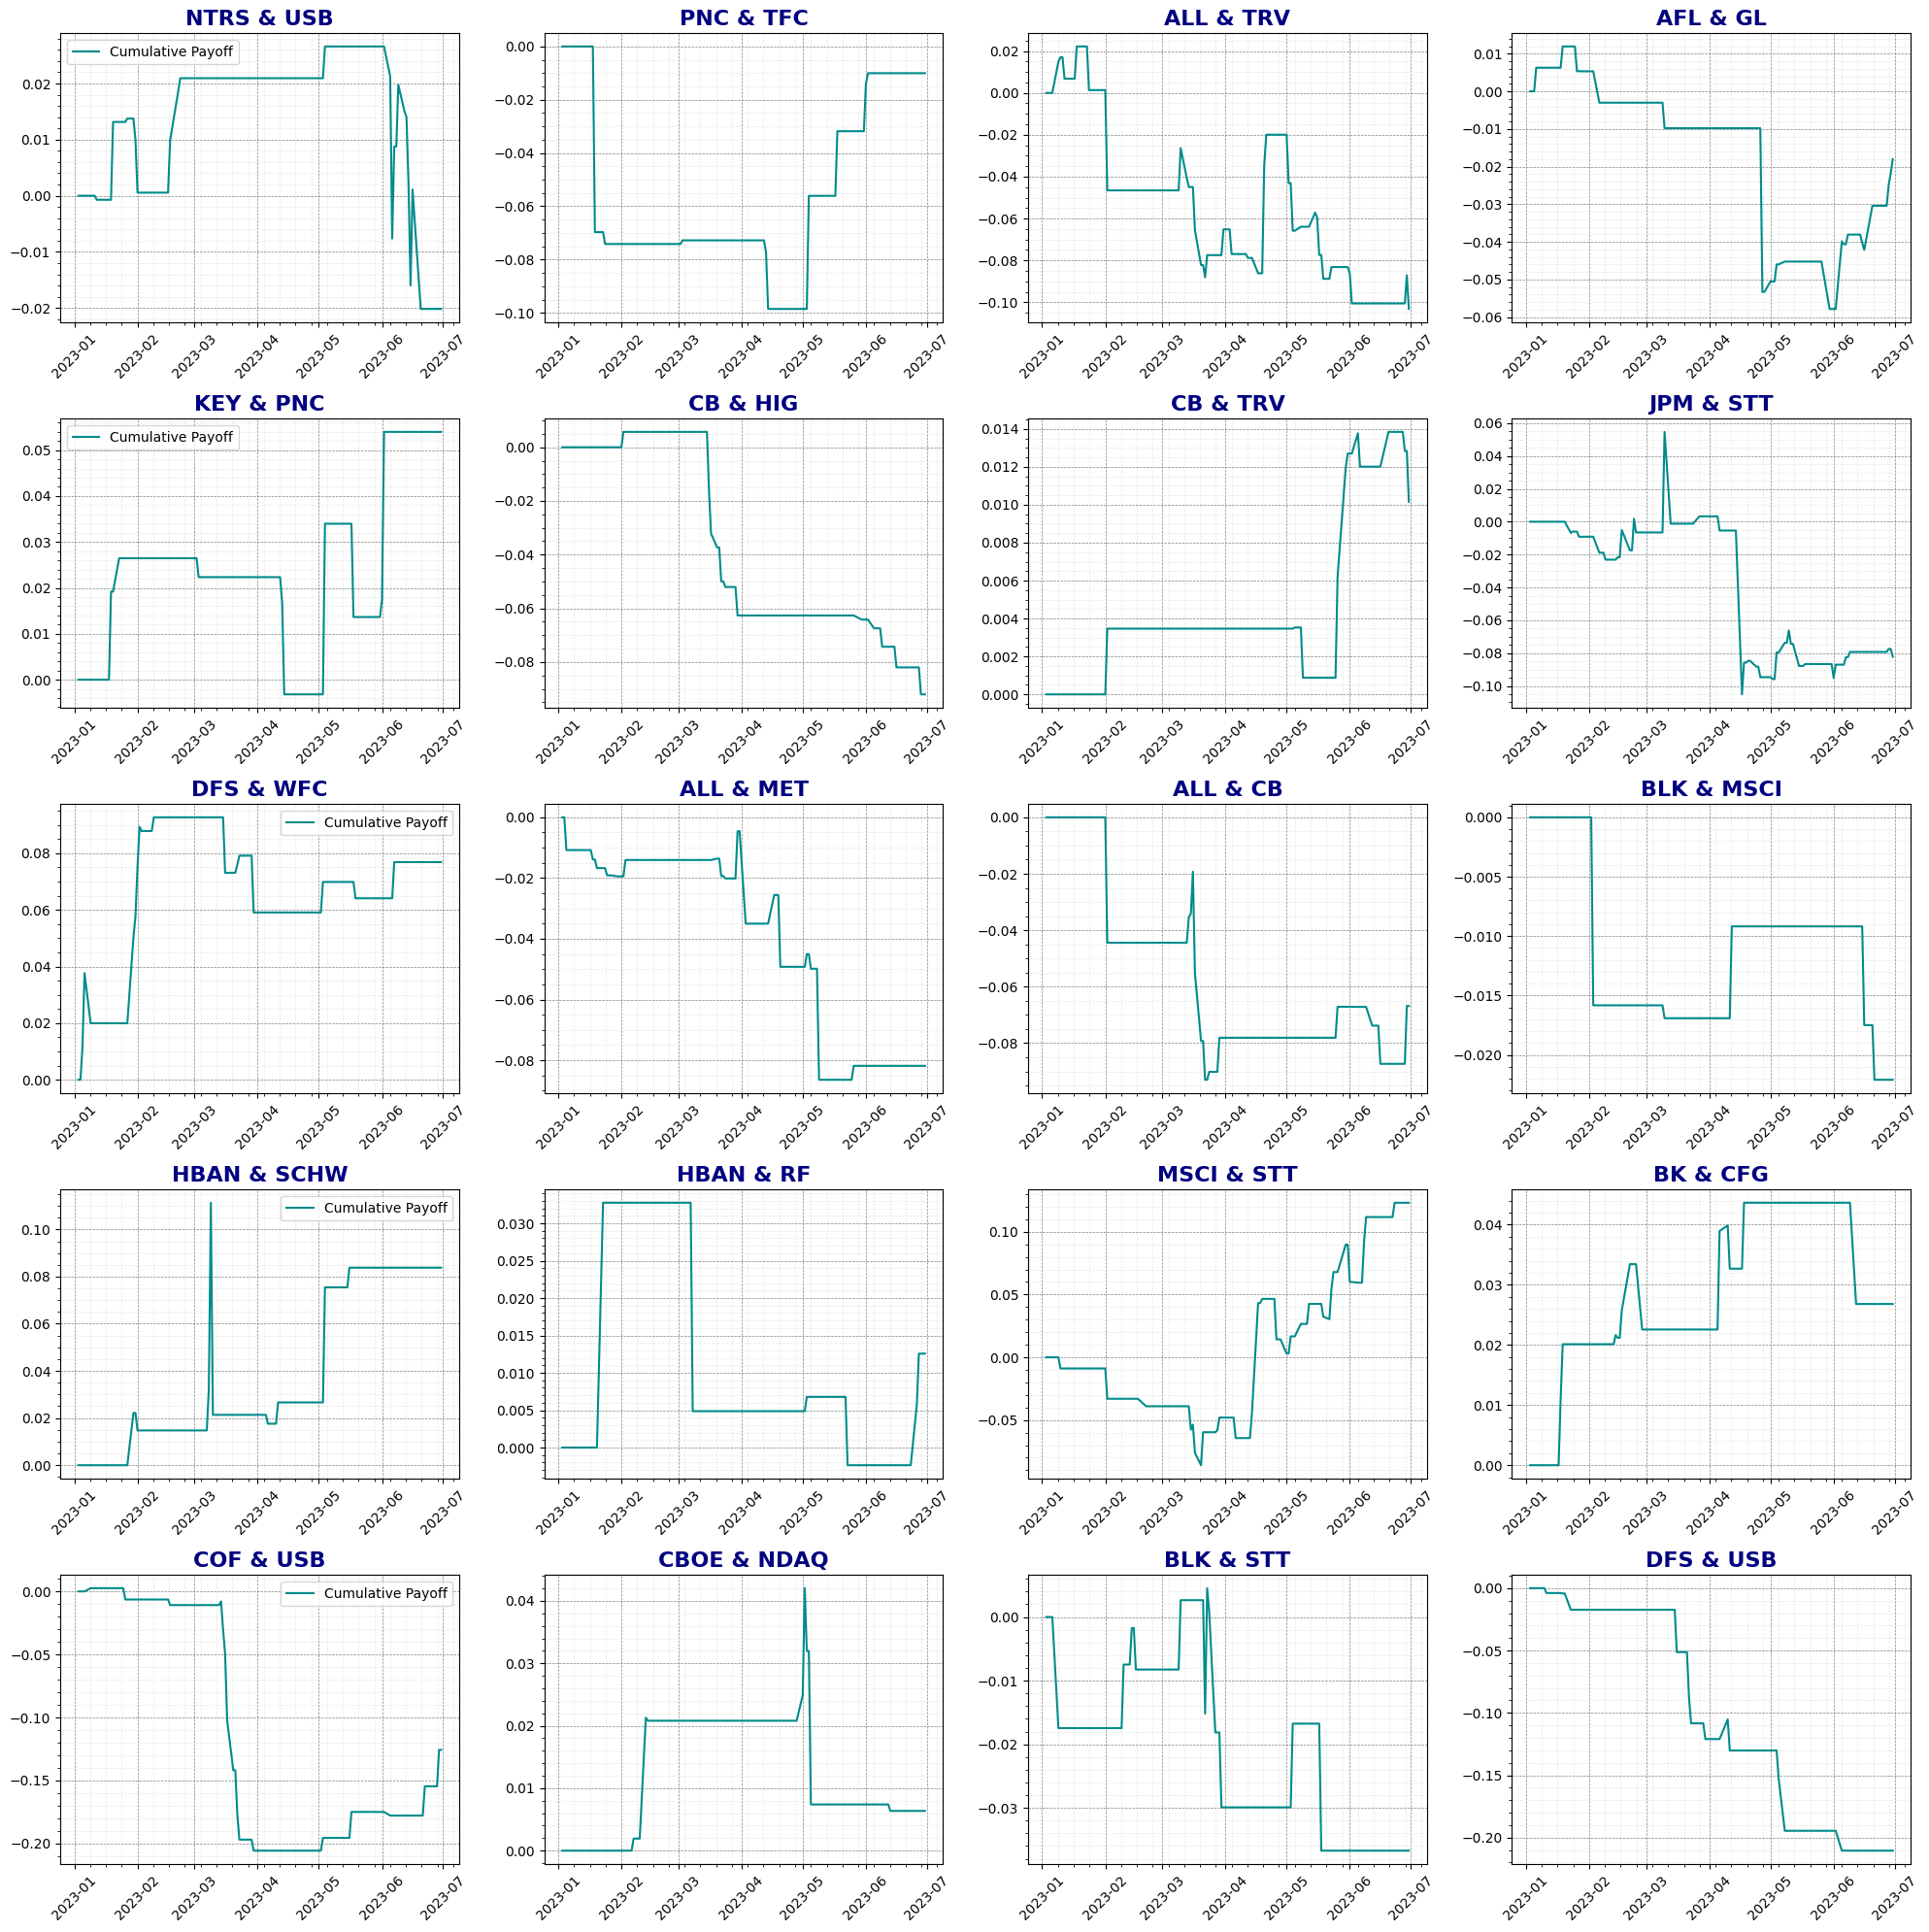

In [10]:
# Plot payoffs of each individual pair

plot_cumulative_payoff_idividual(test_data, signals, pairs)

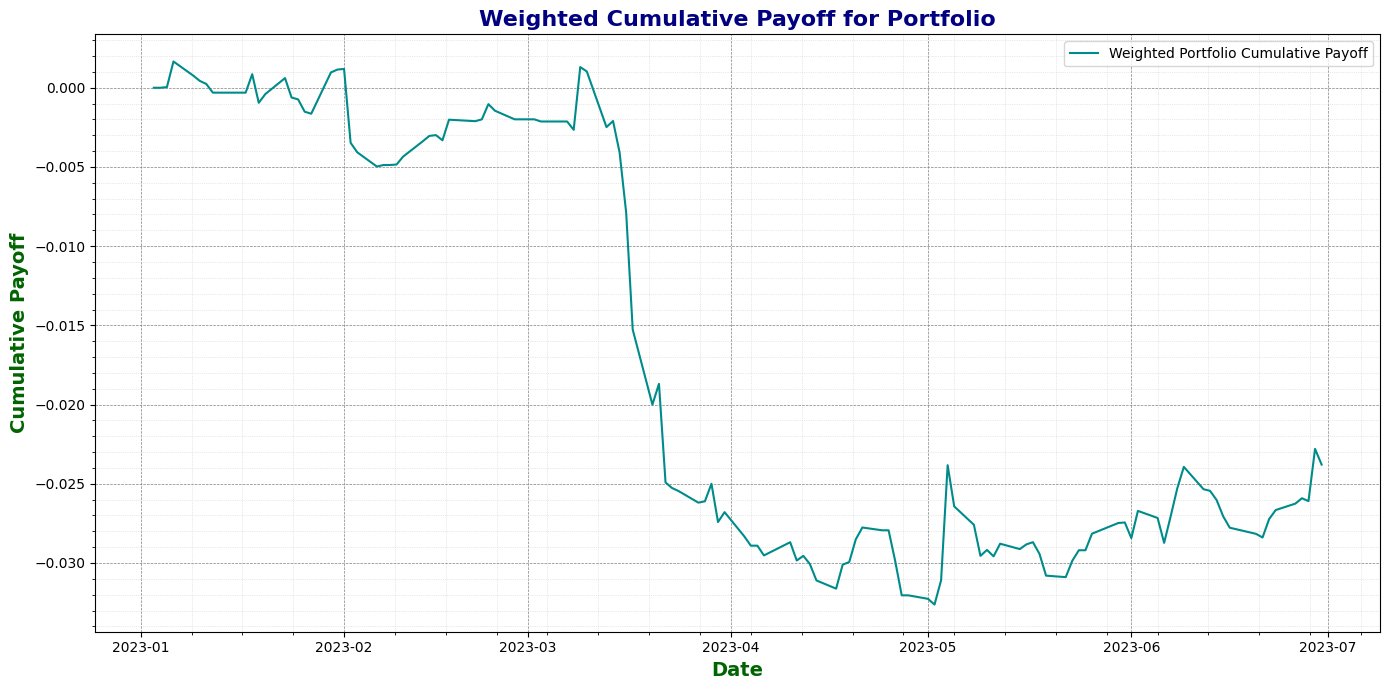

In [11]:
# Plot payoffs of portfolio with equal weights

weights = equal_weighing_scheme(pairs)
plot_cumulative_payoff_portfolio_weighted(test_data, signals, pairs, weights)